In [34]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

def fullfisher_inv(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    Q = a[:, None]*a[None, :]
    term = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    kernel = xo.gp.terms.KroneckerTerm(term, Q)
    diag = diag * np.ones((len(a), len(t)))
    gp = xo.gp.GP(kernel=kernel, diag=diag, x=t, J=2*len(a))
    dtrans = utils.transit(t, *tparams)
    x = tt.dmatrix()
    y = tt.dmatrix()
    f = theano.function([x, y], [x.T.dot(gp.apply_inverse_vector(y))])
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = f(x, y)[0][0, 0]
    return fish

def fisher(t, tparams, gpparams, a=[1]):
    fish = fullfisher_inv(t, tparams, gpparams, a=a)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

def fisher_white_noise_only(t, tparams, diag):
    dtrans = utils.transit(t, *tparams)
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        fish[i, j] = (1/diag)*x.T.dot(y)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

t = np.linspace(-5, 5, 3000)
tparams = [0.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 10)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

w0T = 0.1
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

In [ ]:
oneband = [fisher(t, tparams, [ls + 2*np.log(np.mean(a)), logw0, logq, d]) for ls, d in zip(logs0, diag)]
oneband = np.array(oneband).T
np.savetxt('data/fisher_oneband_{0}.txt'.format(w0T), oneband)

twoband = [fisher(t, tparams, [ls, logw0, logq, 2*d], a=a) for ls, d, in zip(logs0, diag)]
twoband = np.array(twoband).T
np.savetxt('data/fisher_twoband_{0}.txt'.format(w0T), twoband)

In [ ]:
oneband = np.loadtxt('data/fisher_oneband_{0}.txt'.format(0.1))
twoband = np.loadtxt('data/fisher_twoband_{0}.txt'.format(0.1))

pl.semilogy(x, oneband[0], color=red)
pl.semilogy(x, oneband[1], color=green)
pl.semilogy(x, oneband[2], color=blue)
pl.semilogy(x, oneband[3], color=yellow)

pl.semilogy(x, twoband[0], color=red)
pl.semilogy(x, twoband[1], color=green)
pl.semilogy(x, twoband[2], color=blue)
pl.semilogy(x, twoband[3], color=yellow)

In [ ]:
t = np.linspace(-5, 5, 3000)
tparams = [0.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 50)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

oneband1 = [fisher_white_noise_only(t, tparams, d) for d in diag]
oneband1 = np.array(oneband1).T
np.savetxt('data/fisher_white_noise_only_1.txt', oneband1)

oneband5 = [fisher_white_noise_only(t, tparams, 10*d) for d in diag]
oneband5 = np.array(oneband5).T
np.savetxt('data/fisher_white_noise_only_root5.txt', oneband5)

In [ ]:
x = np.linspace(-3, 3, 50)
twoband = np.loadtxt('data/fisher_twoband_{0}.txt'.format(10))
oneband1 = np.loadtxt('data/fisher_white_noise_only_1.txt')
oneband5 = np.loadtxt('data/fisher_white_noise_only_root5.txt')

fig, ax = pl.subplots(2, 2, figsize=(20, 14), sharex=True, sharey=True)
pl.subplots_adjust(hspace=0, wspace=0)

ax = np.array(ax).flatten()

#pl.figure(figsize=(10, 7))
ax[0].semilogy(x, oneband1[0], '--', color='k', linewidth=2)
ax[0].semilogy(x, oneband5[0], '--', color='k', linewidth=2)
ax[0].semilogy(x, twoband[0], color=red)
ax[0].annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.12, 0.85-0.045), xycoords='axes fraction', fontsize=18)
ax[0].annotate(r"$\sigma'=\sigma$", xy=(0.12, 0.755-0.045), xycoords='axes fraction', fontsize=18)
ax[0].annotate(r"$t_0$", xy=(0.8, 0.8), xycoords='axes fraction', fontsize=40)
#ax[0].set_xlabel(r"$\log(\alpha/\sigma)$")
#ax[0].set_ylabel("1-sigma uncertainty")
#ax[0].set_ylim(oneband5[0, -1]/5, oneband5[0, 0]*5)
#pl.savefig('plots/fisher_t0.pdf')

#pl.figure(figsize=(10, 7))
ax[1].semilogy(x, oneband1[1], '--', color='k', linewidth=2)
ax[1].semilogy(x, oneband5[1], '--', color='k', linewidth=2)
ax[1].semilogy(x, twoband[1], color=green)
#ax[1].annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='axes fraction', fontsize=18)
#ax[1].annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='axes fraction', fontsize=18)
ax[1].annotate(r"$R_p/R_*$", xy=(0.75, 0.8), xycoords='axes fraction', fontsize=40)
#ax[1].set_xlabel(r"$\log(\alpha/\sigma)$")
#ax[1].set_ylabel("1-sigma uncertainty")
#ax[1].set_ylim(oneband5[1, -1]/5, oneband5[1, 0]*5)
#pl.savefig('plots/fisher_rp.pdf')

#pl.figure(figsize=(10, 7))
ax[2].semilogy(x, oneband1[2], '--', color='k', linewidth=2)
ax[2].semilogy(x, oneband5[2], '--', color='k', linewidth=2)
ax[2].semilogy(x, twoband[2], color=blue)
#ax[2].annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='axes fraction', fontsize=18)
#ax[2].annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='axes fraction', fontsize=18)
ax[2].annotate(r"$\Delta t$", xy=(0.8, 0.8), xycoords='axes fraction', fontsize=40)
#ax[2].set_xlabel(r"$\log(\alpha/\sigma)$")
#ax[2].set_ylabel("1-sigma uncertainty")
#ax[2].set_ylim(oneband5[2, -1]/5, oneband5[2, 0]*5)
#pl.savefig('plots/fisher_dt.pdf')

#pl.figure(figsize=(10, 7))
ax[3].semilogy(x, oneband1[3], '--', color='k', linewidth=2)
ax[3].semilogy(x, oneband5[3], '--', color='k', linewidth=2)
ax[3].semilogy(x, twoband[3], color=yellow)
#ax[3].annotate(r"$\sigma'=\sqrt{10}\sigma$", xy=(0.19, 0.85-0.08), xycoords='axes fraction', fontsize=18)
#ax[3].annotate(r"$\sigma'=\sigma$", xy=(0.2, 0.755-0.07), xycoords='axes fraction', fontsize=18)
ax[3].annotate(r"$t_{in}$", xy=(0.8, 0.8), xycoords='axes fraction', fontsize=40)
#ax[3].set_xlabel(r"$\log(\alpha/\sigma)$")
#ax[3].set_ylabel("1-sigma uncertainty")
ax[3].set_ylim(oneband5[1, -1]/5, oneband5[3, 0]*5)
#pl.savefig('plots/fisher_tin.pdf')
ax[3].annotate(r'$\log{(\alpha/\sigma)}$', xy=(0.46, 0.03), xycoords='figure fraction', fontsize=30)
ax[3].annotate(r'1-sigma uncertainty', xy=(0.02, 0.67), xycoords='figure fraction', fontsize=30, rotation=90)
pl.savefig('plots/fisher_separate.pdf')

In [ ]:
q = 5, 2, 1/np.sqrt(2), 0.3, 0.1
kernel = [xo.gp.terms.SHOTerm(log_S0=-5, log_w0=0, log_Q=lq) for lq in np.log(q)]
f = np.logspace(-3, 1, 1000)
omega = 2*np.pi*f
psd = np.array([k.psd(omega).eval() + 0.001*np.ones_like(omega) for k in kernel])
psd /= 2*np.pi

In [ ]:
pl.figure(figsize=(10, 7))
colors = [red, blue, yellow, green, darkblue]
labels = r"$Q = 5$", r"$Q = 2$", r"$Q = 1/\sqrt{2}$", r"$Q=0.3$", r"$Q=0.1$" 
[pl.loglog(f, p, color=colors[i], label=labels[i]) for i, p in enumerate(psd)]
pl.legend()
pl.xlabel("frequency (Hz)")
pl.ylabel(r"power (ppm$^2$/Hz)")
pl.savefig("plots/sho_psd.pdf")

In [ ]:
pl.figure(figsize=(10, 7))

w0 = np.array([0.1, 0.5, 10.0])*2*np.pi
kernel = [xo.gp.terms.SHOTerm(log_S0=-5, log_w0=lw, log_Q=-np.log(np.sqrt(2))) for lw in np.log(w0)]
f = np.logspace(-1.5, 2, 1000)
omega = 2*np.pi*f
psd = np.array([k.psd(omega).eval() + 0.001*np.ones_like(omega) for k in kernel])
psd /= 2*np.pi

colors = [red, blue, green]
labels = "regime I", "regime II", "regime III" 
[pl.loglog(f, p, color=colors[i], label=labels[i]) for i, p in enumerate(psd)]
pl.axvspan(xmin=1/tparams[2], xmax=1/tparams[3], color='k', alpha=0.15)
pl.axvline(1/tparams[2], color='k', linewidth=3, alpha=0.8)
pl.axvline(1/tparams[3], color='k', linewidth=3, alpha=0.8)
#pl.annotate(r"$t_{in}^{-1}$", xy=(0.2, 2e-3), xycoords='data', rotation=45, fontsize=20)
#pl.annotate(r"$\Delta t^{-1}$", xy=(0.5, 2.3e-3), xycoords='data', rotation=45, fontsize=20)
#pl.ylim(1e-4, 5e-3)
pl.legend(loc='upper right')
pl.xlabel("frequency (Hz)")
pl.ylabel(r"power (ppm$^2$/Hz)")
pl.ylim(1e-4, 2e-3)
pl.savefig("plots/psd_regimes.pdf")

In [ ]:
t = np.linspace(0, 100, 1000)
n = np.random.randn(len(t), 1)
gp = [xo.gp.GP(kernel=k, J=2, diag=0.001*np.ones_like(t), x=t) for k in kernel]
y = [gp.dot_l(n).eval() for gp in gp]

In [ ]:
pl.figure(figsize=(10, 7))
colors = [red, blue, yellow, green, darkblue]
labels = r"$Q = 5$", r"$Q = 2$", r"$Q = 1/\sqrt{2}$", r"$Q=0.3$", r"$Q=0.1$" 
[pl.plot(t, flux + 0.5*i, '.', color=colors[::-1][i], label=labels[i]) for i, flux in enumerate(y[::-1])]
#pl.legend()
pl.xlabel("time")
pl.ylabel("flux")
pl.savefig("plots/samples.pdf")

In [ ]:
Q = np.array([1, 2])
Q = Q[None, :]*Q[:, None]
gp = xo.gp.GP(kernel=kernel[2], J=4, diag=0.001*np.ones((2, len(t))), x=t, Q=Q)

In [ ]:
y = gp.dot_l(np.random.randn(2*len(t), 1)).eval()
b1, b2 = y[1::2], y[::2]

In [ ]:
import matplotlib.patches as mpatches

fig = pl.figure(figsize=(20, 7))
pl.plot(t, b1+0.5, '.', color=blue, markersize=10)
pl.plot(t, b2-0.5, '.', color=red, markersize=10)
pl.plot(t + 150, (b1+b2)/2, 'k.', markersize=10)
pl.gca().annotate("", xy=(145, -0.1), xytext=(105, -0.4), 
            arrowprops=dict(arrowstyle="fancy",
                            color="k",
                            alpha=0.5,
                            shrinkB=2,
                            connectionstyle="arc3,rad=-0.2",
                            mutation_scale=50))

pl.gca().annotate("", xy=(145, 0.1), xytext=(105, 0.4), 
            arrowprops=dict(arrowstyle="fancy",
                            color="k",
                            alpha=0.5,
                            shrinkB=2,
                            connectionstyle="arc3,rad=0.2",
                            mutation_scale=50)
                 )

pl.gca().annotate("blue band", xy=(0, 0.9), fontsize=40, color=blue, weight='bold')
pl.gca().annotate("red band", xy=(0, -0.25), fontsize=40, color=red, weight='bold')
pl.gca().annotate("monochromatic", xy=(150, 0.35), fontsize=40, color='k', weight='bold')

pl.ylim(-1, 1)
pl.xlim(-1, 251)

fig.tight_layout()
fig.patch.set_visible('False')
fig.gca().axis('off')

pl.savefig('plots/schematic.pdf', bbox_inches='tight')

In [ ]:
import mcmc

fig, ax = pl.subplots(3, 2, figsize=(20, 10), sharex=True, sharey=True)
pl.subplots_adjust(hspace=0, wspace=0)


t = np.linspace(0, 20, 3000)
tparams = [10.0, 0.1, 1.0, 0.2]  # t0, r, d, tin

alpha = -13 # total variance 
x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)
a = [1, 2]

w0T = 0.1
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[0, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[0, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[0, 1].plot(t, y1d, '.', color='k')
ax[0, 1].annotate("regime I", xy=(16, 1.01), fontsize=25)
#pl.savefig('plots/regime1.pdf')

x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)

w0T = 0.5
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[1, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[1, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[1, 1].plot(t, y1d, '.', color='k')
ax[1, 1].annotate("regime II", xy=(16, 1.01), fontsize=25)
#pl.savefig('plots/regime2.pdf')

x = np.linspace(-3, 3, 20)
logr = np.log(10 ** x)
logsig = 0.5 * (alpha - np.log(1 + np.exp(2*logr)))
logs0 = logr + logsig
logq = np.log(1/np.sqrt(2))
diag = np.exp(2*logsig)

w0T = 10.0
logw0 = np.log(w0T) - np.log(tparams[2])
logs0 = 2 * logs0  - logw0

logs0 = logs0[11]
diag = diag[11]
logsig = logsig[11]

y2d, y1d = mcmc.make_data(t, logs0 + 2*np.log(np.mean(a)), logw0, 
                              logq, logsig, 
                              tparams[0], tparams[1], 
                              tparams[2], tparams[3], a[1])

#fig = pl.figure(figsize=(10, 7))
ax[2, 0].plot(t, y2d[::2]-0.008, '.', color=red)
ax[2, 0].plot(t, y2d[1::2]+0.008, '.', color=blue)
ax[2, 1].plot(t, y1d, '.', color='k')
ax[2, 1].annotate("regime III", xy=(16, 1.01), fontsize=25)

[ax.set_ylim(0.97, 1.02) for ax in np.array(ax).flatten()]
ax[2, 1].annotate("normalized flux", xy=(0.025, 0.7), xycoords='figure fraction', rotation=90, fontsize=30)
ax[2, 1].annotate("time (days)", xy=(0.5, 0.02), xycoords='figure fraction', fontsize=30)
pl.savefig('plots/regimes.pdf')

In [ ]:
tparams = [10, 0.1, 5, 2]

fig = pl.figure(figsize=(10, 5))
pl.plot(t, utils.transit(t, *tparams)[0], 'k')

pl.gca().annotate("", xy=(tparams[0]-tparams[2]/2-tparams[3], 0.99+0.01), 
                  xytext=(tparams[0]-tparams[2]/2, 0.99+0.01), 
                  xycoords='data', fontsize=18, 
                  arrowprops=dict(arrowstyle="<->",
                            color="k", linewidth=2))

pl.gca().annotate("", xy=(tparams[0]-tparams[2]/2, 0.99+0.005), 
                  xytext=(tparams[0]+tparams[2]/2, 0.99+0.005), 
                  xycoords='data', fontsize=18, 
                  arrowprops=dict(arrowstyle="<->",
                            color="k", linewidth=2))

pl.gca().annotate("", xy=(tparams[0]+tparams[2]/2 + 2.5, 1.0), 
                  xytext=(tparams[0]+tparams[2]/2 + 2.5, 0.99), 
                  xycoords='data', fontsize=18, 
                  arrowprops=dict(arrowstyle="<->",
                            color="k", linewidth=2))

pl.gca().annotate(r"$t_{in}$", xy=(tparams[0]-tparams[2]/2-tparams[3]/2-0.7, 0.99+0.0105), 
                  xycoords='data', fontsize=30)

pl.gca().annotate(r"$\Delta t$", xy=(tparams[0]-tparams[2]/2+1.5, 0.99+0.0055), 
                  xycoords='data', fontsize=30)

pl.gca().annotate(r"$\left(\frac{R_p}{R_*}\right)^{^2}$", xy=(tparams[0]-tparams[2]/2+8, 0.99+0.004), 
                  xycoords='data', fontsize=30)

fig.patch.set_visible('False')
fig.gca().axis('off')
pl.savefig('plots/transit.pdf')

In [ ]:
def sigma_rp_2(x, alpha, sig1, sig2):
    alpha = 4*alpha
    prefactor = (1/(sig1 ** 2) + 1/(sig2 ** 2)) ** -1
    numerator = 1 + (alpha ** 2) * (((sig1 ** 2) ** -1) + (((1+1/x)*(sig2 ** 2)) ** -1))
    denominator = 1 + x + (alpha **2) * (1+x) / ((sig1 ** 2) + (sig2 ** 2))
    return prefactor * numerator / denominator

def sigma_rp_1(x, alpha, sig1, sig2):
    prefactor = (1/(sig1 ** 2) + 1/(sig2 ** 2)) ** -1
    numerator = alpha / (sig1 ** 2) + x * alpha / (sig2 ** 2)
    return prefactor + prefactor * numerator

In [ ]:
import numpy as np
import matplotlib.pyplot as pl

x = np.linspace(1, 10, 10)
alpha = np.exp(-10)
sig1 = np.exp(-10)
sig2 = np.exp(-10)
unc2 = sigma_rp_2(x, alpha, sig1, sig2)
unc1 = sigma_rp_1(x, alpha, sig1, sig2)
pl.plot(x, unc2/unc1)

In [37]:
x = np.linspace(1, 10, 10)
diag = np.exp(-15)
alpha = np.exp(-5)
alpha1 = 2 / (1 + x)
alpha2 = 2 / (1 + 1/x)
sig = np.sqrt(diag)
a = np.array([alpha1, alpha2]).T
a3 = [np.linspace(a1, a2, 3) for (a1, a2) in zip(alpha1, alpha2)]
a4 = [np.linspace(a1, a2, 4) for (a1, a2) in zip(alpha1, alpha2)]
a5 = [np.linspace(a1, a2, 5) for (a1, a2) in zip(alpha1, alpha2)]
t = np.linspace(-5, 5, 5000)
tparams = [0.0, 0.1, 1.0, 0.01]  # t0, r, d, tin
logw0 = 5.0
fish1 = [fisher(t, tparams, [-100, logw0, logq, diag]) for a in a]
fish2 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a) for a in a]
fish3 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a) for a in a3]
fish4 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a) for a in a4]
fish5 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a) for a in a5]
#unc2 = sigma_rp_2(x, alpha, sig, sig)
#unc1 = sigma_rp_1(x, alpha, sig, sig)

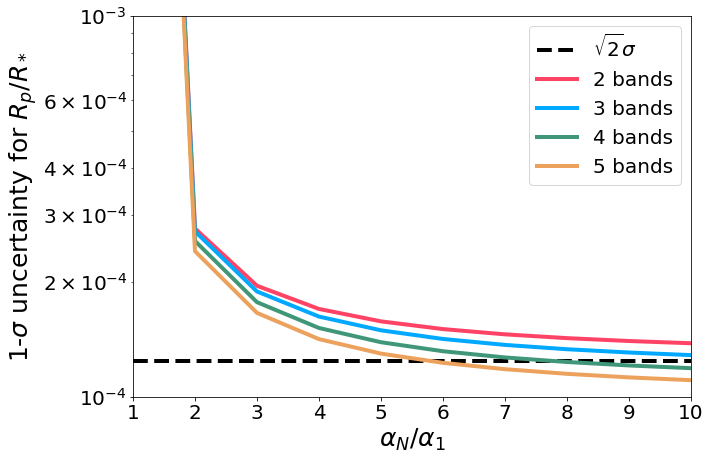

In [43]:
figure = pl.figure(figsize=(10, 7))
pl.semilogy(x, np.array(fish1)[:, 1], '--', color='k', label=r"$\sqrt{2}\sigma$")
pl.semilogy(x, np.array(fish2)[:, 1], '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3)[:, 1], '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4)[:, 1], '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5)[:, 1], '-', color=yellow, label="5 bands")
pl.legend()
#pl.xlim((1, 10))
#pl.ylim(1e-4, 1e-3)
pl.xlabel(r"$\alpha_N/\alpha_1$")
pl.ylabel(r"1-$\sigma$ uncertainty for $R_p/R_*$")
pl.savefig("/Users/tgordon/Desktop/fisher_alpha.pdf")

In [ ]:
np.array(fish2)[:, 1]

In [ ]:
[np.mean(alpha) for a in a]

In [ ]:
a / np.exp(logs0[9])